In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

import os
import gc
from pathlib import Path

from IPython.display import FileLink
print(os.listdir("../input"))

['data']


## Data prep

In [2]:
DATA_DIR = Path('../input/data')

In [3]:
train_df = pd.DataFrame(np.load(DATA_DIR/'train_index.npy'), columns=['node1_id', 'node2_id'])
train_df['is_chat'] = np.load(DATA_DIR/'train_label.npy')

In [4]:
train_df.head()

,node1_id,node2_id,is_chat
0,867016,4225125,0
1,1589846,4770671,0
2,2571454,504474,0
3,2901855,2406550,0
4,4728168,785584,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61559580 entries, 0 to 61559579
Data columns (total 3 columns):
node1_id    int32
node2_id    int32
is_chat     int8
dtypes: int32(2), int8(1)
memory usage: 528.4 MB


In [6]:
test_df = pd.DataFrame(np.load(DATA_DIR/'test.npy'), columns=['id', 'node1_id', 'node2_id'])

In [7]:
test_df.head()

,id,node1_id,node2_id
0,1,3990626,4502971
1,2,4488254,1592155
2,3,1591233,4546377
3,4,2737640,4164200
4,5,2856520,2556652


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11776968 entries, 0 to 11776967
Data columns (total 3 columns):
id          int32
node1_id    int32
node2_id    int32
dtypes: int32(3)
memory usage: 134.8 MB


In [9]:
"""
user_df = pd.DataFrame(np.load(DATA_DIR/'users_index.npy'), columns=['index', 'node_id'])
user_feat = pd.DataFrame(np.load(DATA_DIR/'users_feat.npy'), columns=['f' + str(i) for i in range(1, 14)])
user_df = pd.concat([user_df, user_feat], axis=1)
del user_feat
gc.collect()
"""

"\nuser_df = pd.DataFrame(np.load(DATA_DIR/'users_index.npy'), columns=['index', 'node_id'])\nuser_feat = pd.DataFrame(np.load(DATA_DIR/'users_feat.npy'), columns=['f' + str(i) for i in range(1, 14)])\nuser_df = pd.concat([user_df, user_feat], axis=1)\ndel user_feat\ngc.collect()\n"

In [10]:
"""
user_df[['f' + str(i) for i in range(1,13)]] = user_df[['f' + str(i) for i in range(1,13)]]/31
"""

"\nuser_df[['f' + str(i) for i in range(1,13)]] = user_df[['f' + str(i) for i in range(1,13)]]/31\n"

In [11]:
"""
user_df.drop(['node_id'], axis=1, inplace=True)
user_df['index'] = user_df['index'] + 1
user_df['index'] = user_df['index'].astype(np.int32)
"""

"\nuser_df.drop(['node_id'], axis=1, inplace=True)\nuser_df['index'] = user_df['index'] + 1\nuser_df['index'] = user_df['index'].astype(np.int32)\n"

In [12]:
train_df['node1_id'] = train_df['node1_id'] + 1
train_df['node2_id'] = train_df['node2_id'] + 1

test_df['node1_id'] = test_df['node1_id'] + 1
test_df['node2_id'] = test_df['node2_id'] + 1

In [13]:
train_df['node1_id'] = train_df['node1_id'].astype(np.int32)
train_df['node2_id'] = train_df['node2_id'].astype(np.int32)

test_df['node1_id'] = test_df['node1_id'].astype(np.int32)
test_df['node2_id'] = test_df['node2_id'].astype(np.int32)

In [14]:
gc.collect()

31

In [15]:
all_edges_df = pd.concat([train_df[['node1_id', 'node2_id']], test_df[['node1_id', 'node2_id']]])

In [16]:
all_edges_df = pd.concat([all_edges_df, all_edges_df[['node2_id', 'node1_id']].rename(columns={'node1_id': 'node2_id', 'node2_id': 'node1_id'})])

In [17]:
all_edges_df.reset_index(drop=True, inplace=True)

In [18]:
all_edges_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146673096 entries, 0 to 146673095
Data columns (total 2 columns):
node1_id    int32
node2_id    int32
dtypes: int32(2)
memory usage: 1.1 GB


In [19]:
gc.collect()

7

In [20]:
all_edges_df.shape

(146673096, 2)

In [21]:
all_edges_df.head()

,node1_id,node2_id
0,867017,4225126
1,1589847,4770672
2,2571455,504475
3,2901856,2406551
4,4728169,785585


In [22]:
del train_df, test_df
gc.collect()

11

In [23]:
gc.collect()

0

In [24]:
from keras.preprocessing.sequence import pad_sequences
import dask.dataframe as dd

all_edges_dd= dd.from_pandas(all_edges_df, npartitions=50)

Using TensorFlow backend.


In [25]:
nodes_result = all_edges_dd.groupby('node1_id').apply(lambda x: pad_sequences([list(set(x['node2_id']))], maxlen=60, dtype='int32', padding='post', truncating='post', value=0.0)[0]).compute()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [26]:
nodes_result.shape

(4978236,)

In [27]:
gc.collect()

165

In [28]:
del all_edges_df, all_edges_dd
gc.collect()

0

In [29]:
gc.collect()

0

In [30]:
"""
node_inds = nodes_result.index
nodes_result = pd.DataFrame(nodes_result.tolist(), columns=['n' + str(i) for i in range(1,61)], index=node_inds)
b_x = pd.merge(left=b_x, right=ps_ans_df, left_on='node1_id', right_on='node1_id', how='left')
b_x = pd.merge(left=b_x, right=ps_ans_df, left_on='node2_id', right_on='node1_id', how='left')
"""

"\nnode_inds = nodes_result.index\nnodes_result = pd.DataFrame(nodes_result.tolist(), columns=['n' + str(i) for i in range(1,61)], index=node_inds)\nb_x = pd.merge(left=b_x, right=ps_ans_df, left_on='node1_id', right_on='node1_id', how='left')\nb_x = pd.merge(left=b_x, right=ps_ans_df, left_on='node2_id', right_on='node1_id', how='left')\n"

In [31]:
nodes_result[0:2]

node1_id
21     [3936387, 3494276, 3520262, 3368071, 614025, 4...
191    [1520023, 1178975, 1042855, 3822951, 3676392, ...
dtype: object

In [179]:
train_df = pd.DataFrame(np.load(DATA_DIR/'train_index.npy'), columns=['node1_id', 'node2_id'])
train_df['is_chat'] = np.load(DATA_DIR/'train_label.npy')

train_df['node1_id'] = train_df['node1_id'] + 1
train_df['node2_id'] = train_df['node2_id'] + 1

train_df['node1_id'] = train_df['node1_id'].astype(np.int32)
train_df['node2_id'] = train_df['node2_id'].astype(np.int32)

In [180]:
gc.collect()

585

In [34]:
train_df = train_df.sort_values(['node1_id', 'node2_id'])
train_df.reset_index(drop=True, inplace=True)
train_df['node1_id'] = train_df['node1_id'].astype(np.int32)
train_df['node2_id'] = train_df['node2_id'].astype(np.int32)
gc.collect()

14

In [35]:
train_df.head()

,node1_id,node2_id,is_chat
0,1,1,0
1,1,81732,0
2,1,117593,0
3,1,570870,0
4,1,646948,0


In [36]:
gc.collect()

11

In [37]:
test_df = pd.DataFrame(np.load(DATA_DIR/'test.npy'), columns=['id', 'node1_id', 'node2_id'])

test_df['node1_id'] = test_df['node1_id'] + 1
test_df['node2_id'] = test_df['node2_id'] + 1

test_df['node1_id'] = test_df['node1_id'].astype(np.int32)
test_df['node2_id'] = test_df['node2_id'].astype(np.int32)

In [38]:
user_df = pd.DataFrame(np.load(DATA_DIR/'users_index.npy'), columns=['index', 'node_id'])
user_feat = pd.DataFrame(np.load(DATA_DIR/'users_feat.npy'), columns=['f' + str(i) for i in range(1, 14)])
user_df = pd.concat([user_df, user_feat], axis=1)
del user_feat

user_df.drop(['node_id'], axis=1, inplace=True)

user_df['index'] = user_df['index'] + 1
user_df['index'] = user_df['index'].astype(np.int32)

user_df[['f' + str(i) for i in range(1,13)]] = user_df[['f' + str(i) for i in range(1,13)]]/31

gc.collect()

7

In [40]:
gc.collect()

0

In [ ]:
# we have nodes_result, train_df, test_df, user_df

In [44]:
user_df.shape

(4978236, 14)

In [202]:
del test_df

In [203]:
gc.collect()

7

In [221]:
for i in range(1,13):
    user_df['f' + str(i)] = user_df['f' + str(i)].astype(np.float32)

In [223]:
gc.collect()

613

In [224]:
from sklearn.model_selection import train_test_split

from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dropout, BatchNormalization, SpatialDropout1D, Lambda, merge, RepeatVector
from keras.layers import GlobalAveragePooling1D, GlobalMaxPool1D
from keras.models import Model
from keras.optimizers import  Adam, SGD
from keras.utils import Sequence

import keras.backend as K
K.set_floatx('float16')
K.set_epsilon(1e-4) #default epsilon is 1e-7

In [ ]:
# trn_df , tst_df = train_test_split(train_df, test_size= 0.1, stratify=train_df['is_chat'], random_state=0)
# trn_df.reset_index(drop=True, inplace=True)
# tst_df.reset_index(drop=True, inplace=True)

In [42]:
# https://github.com/bckenstler/CLR/blob/master/clr_callback.py

from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
"""
# Data generator and feature creation on the fly

class MY_Generator(Sequence):
    def __init__(self, data, user_feats, node_nbrs, batch_size):
        self.data, self.user_feats, self.node_nbrs = data, user_feats, node_nbrs
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch = self.data[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        
        batch = pd.merge(left=batch, right=self.user_feats, left_on='node1_id', right_on='index', how='left').drop(['index'], axis=1)
        batch = pd.merge(left=batch, right=self.user_feats, left_on='node2_id', right_on='index', how='left').drop(['index'], axis=1)
        
        
        batch
        
        data = {}
        data['node1_id'] = np.array(batch_x['node1_id'])
        data['node2_id'] = np.array(batch_x['node2_id'])
        data['node1_neu'] = np.array(batch_x[['f' + str(i) + '_x' for i in range(1,13)]])
        data['node2_neu'] = np.array(batch_x[['f' + str(i) + '_y' for i in range(1,13)]])
        data['node1_cat'] = np.array(batch_x['f13_x'])
        data['node2_cat'] = np.array(batch_x['f13_y'])
        
        return data, np.array(batch_y)
"""

In [235]:
# Data generator and feature creation on the fly

class Train_Generator(Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __len__(self):
        global train_df
        return int(np.ceil(train_df.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        global train_df
        global user_df
        global nodes_result
        batch = train_df[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        
        batch = pd.merge(left=batch, right=user_df, left_on='node1_id', right_on='index', how='left').drop(['index'], axis=1)
        batch = pd.merge(left=batch, right=user_df, left_on='node2_id', right_on='index', how='left').drop(['index'], axis=1)
        
        
        uniq_nodes = list(set(batch['node1_id'].unique()).union(set(batch['node2_id'].unique())))
        mini_nodes_nebr = pd.DataFrame(nodes_result[uniq_nodes].tolist(), columns=['n' + str(i) for i in range(1,61)])
        mini_nodes_nebr['index'] = uniq_nodes
        
        batch = pd.merge(left=batch, right=mini_nodes_nebr, left_on='node1_id', right_on='index', how='left').drop(['index'], axis=1)
        batch = pd.merge(left=batch, right=mini_nodes_nebr, left_on='node2_id', right_on='index', how='left').drop(['index'], axis=1)
        
        del mini_nodes_nebr
    
        data = {}
    
        data['node1_neu'] = np.array(batch[['f' + str(i) + '_x' for i in range(1,13)]])
        data['node2_neu'] = np.array(batch[['f' + str(i) + '_y' for i in range(1,13)]])
        data['node1_cat'] = np.array(batch['f13_x'])
        data['node2_cat'] = np.array(batch['f13_y'])
        data['node1_nebrs'] = np.array(batch[['n' + str(i) + '_x' for i in range(1,61)]])
        data['node2_nebrs'] = np.array(batch[['n' + str(i) + '_y' for i in range(1,61)]])
        
        return data, np.array(batch['is_chat'])

In [226]:
# model
def get_model():
    inp_node1 = Input(shape=[60], name='node1_nebrs')
    inp_node2 = Input(shape=[60], name='node2_nebrs')
    emb = Embedding(input_dim=user_df.shape[0] + 1, output_dim=20, name='node_embs', mask_zero=True)
    node1_emb = emb(inp_node1)
    node2_emb = emb(inp_node2)
    node1_emb_sum = Lambda(lambda x: K.sum(x, axis=1))(node1_emb)
    node2_emb_sum = Lambda(lambda x: K.sum(x, axis=1))(node2_emb)
    #node1_flat = Flatten()(node1_emb_sum)
    #node2_flat = Flatten()(node2_emb_sum)
    # emb_concat = Concatenate()([node1_emb_sum, node2_emb_sum])
    # emb_out = Dense(20, activation='relu')(emb_concat)

    inp_node1_neu = Input(shape=[12], name='node1_neu')
    inp_node2_neu = Input(shape=[12], name='node2_neu')
    # neu_concat = Concatenate()([inp_node1_neu, inp_node2_neu])
    # neu_out = Dense(10, activation='relu')(neu_concat)
    
    inp_node1_cat = Input(shape=[1], name='node1_cat')
    inp_node2_cat = Input(shape=[1], name='node2_cat')
    emb_cat = Embedding(input_dim=16, output_dim=4, name='cat_embs')
    node1_cat_emb = emb_cat(inp_node1_cat)
    node2_cat_emb = emb_cat(inp_node2_cat)
    node1_cat_flat = Flatten()(node1_cat_emb)
    node2_cat_flat = Flatten()(node2_cat_emb)
    # cat_concat = Concatenate()([node1_cat_flat, node2_cat_flat])
    # cat_out = Dense(4, activation='relu')(emb_concat)
    
    # x = Concatenate()([emb_out, neu_out, cat_out])
    x = Concatenate()([node1_emb_sum, inp_node1_neu, node1_cat_flat, node2_emb_sum, inp_node2_neu, node2_cat_flat])
    x = Dense(20, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(20, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inp_node1, inp_node2, inp_node1_neu, inp_node2_neu, inp_node1_cat, inp_node2_cat], outputs=out)
    return model

In [204]:
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node1_nebrs (InputLayer)        (None, 60)           0                                            
__________________________________________________________________________________________________
node1_cat (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
node2_nebrs (InputLayer)        (None, 60)           0                                            
__________________________________________________________________________________________________
node2_cat (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
node_embs 

In [208]:
train_df[0: int(train_df.shape[0]/6)]['is_chat'].value_counts(normalize=True)

0    0.969741
1    0.030259
Name: is_chat, dtype: float64

In [209]:
int(train_df.shape[0]/ 6)

10259930

In [212]:
int(train_df.shape[0]/ 6) / (4096 * 2)

1252.432861328125

In [213]:
1252/312

4.012820512820513

In [214]:
clr_triangular = CyclicLR(mode='triangular2', step_size=156, base_lr=1e-3, max_lr=8e-3)

model.compile(optimizer=Adam(), loss='binary_crossentropy')

In [232]:
np.random.seed(0)
batch_size = 4096 * 2
num_epochs = 1
num_trn_samples = int(train_df.shape[0]/ 10)

In [236]:
training_batch_generator = Train_Generator(int(batch_size))

In [237]:
gc.collect()

14

In [ ]:
gc.collect()

In [242]:
t1 = time.time()
history = model.fit_generator(generator=training_batch_generator,
                            steps_per_epoch=(num_trn_samples // batch_size),
                            epochs=num_epochs,
                            verbose=1,
                            # shuffle=False,
                            class_weight = {0: 0.1, 1: 0.9},
                            use_multiprocessing=False,
                            # workers=2,
                            # max_queue_size=5,
                            callbacks=[clr_triangular]
                            )
t2 = time.time()

Epoch 1/1


Exception in thread Thread-50:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/opt/conda/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(process_obj)
  File "/opt/conda/lib/python3.6/multiprocessing/pope

  1/751 [..............................] - ETA: 5:37:35 - loss: 0.0567

Exception in thread Thread-66:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/opt/conda/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(process_obj)
  File "/opt/conda/lib/python3.6/multiprocessing/pope

 33/751 [>.............................] - ETA: 1:39:02 - loss: 0.0558

KeyboardInterrupt: 

In [132]:
(t2-t1)/60

6.491252589225769

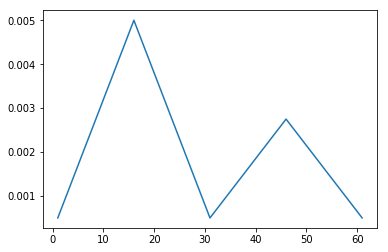

In [133]:
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [ ]:
from clr import LRFinder

In [ ]:
np.random.seed(0)
batch_size = 4096 * 4
num_epochs = 1
num_trn_samples = temp.shape[0]
my_training_batch_generator = MY_Generator(temp[['node1_id', 'node2_id']], temp['is_chat'], user_df, int(batch_size))

In [ ]:
lr_finder = LRFinder(num_trn_samples, batch_size, minimum_lr=1e-3, maximum_lr=10.,
                     lr_scale='exp',
                     validation_sample_rate=5,
                     save_dir='weights/', verbose=True)

In [ ]:
model = get_model()
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.1, momentum=0.9, nesterov=True))

In [ ]:
t1 = time.time()
history = model.fit_generator(generator=my_training_batch_generator,
                            steps_per_epoch=(num_trn_samples // batch_size),
                            epochs=num_epochs,
                            verbose=1,
                            use_multiprocessing=True,
                            workers=2,
                            max_queue_size=64,
                            callbacks=[lr_finder])
t2 = time.time()

In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

In [ ]:
model = get_model()
optimizer = Adam(lr=0.003)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
clr_triangular = CyclicLR(mode='exp_range', base_lr=5e-4, max_lr=5e-3, step_size=169.)

In [ ]:
np.random.seed(0)
batch_size = 4096 * 8
num_epochs = 2
num_trn_samples = trn_df.shape[0]
num_val_samples = tst_df.shape[0]
training_batch_generator = MY_Generator(trn_df[['node1_id', 'node2_id']], trn_df['is_chat'], user_df, int(batch_size))
valid_batch_generator = MY_Generator(tst_df[['node1_id', 'node2_id']], tst_df['is_chat'], user_df, int(batch_size))

In [ ]:
t1 = time.time()
history = model.fit_generator(generator=training_batch_generator,
                            steps_per_epoch=(num_trn_samples // batch_size),
                            validation_data= valid_batch_generator,
                            validation_steps= (num_val_samples // batch_size),
                            epochs=num_epochs,
                            verbose=1,
                            use_multiprocessing=True,
                            workers=2,
                            max_queue_size=64,
                           callbacks=[clr_triangular])
t2 = time.time()

In [ ]:
!nvidia-smi

In [ ]:
model.fit({'node1_id': train_df['node1_id'].values, 'node2_id': train_df['node2_id'].values}, train_df['is_chat'], batch_size=256, epochs=1, validation_split=0.2)

In [ ]:
test_preds = model.predict({'node1_id': test_df['node1_id'].values, 'node2_id': test_df['node2_id'].values})

In [ ]:
sub_df = pd.DataFrame({'id': test_df['id'].values, 'is_chat': test_preds.flatten()})

In [ ]:
sub_df.to_csv('sub.csv', index=False)

In [ ]:
!zip sub.zip sub.csv

In [ ]:
!ls -lh

In [ ]:
FileLink('sub.zip')

https://www.kaggle.com/danmoller/keras-training-with-float16-test-kernel-2